# 0. Preparing

## Format the cell output

In [1]:
from IPython.core.display import HTML

HTML(
    """<style>div.output_area pre{white-space: pre;}</style>
    <script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>."""
)

## Format the cell output

In [2]:
from IPython.core.display import HTML

HTML("""<style>div.output_area pre{white-space: pre;}</style>""")

## Create Spark Session on top of YARN

In [3]:
import pyspark

spark = (
    pyspark.sql.SparkSession.builder.appName("ExploratoryDataAnalysis")
    .master("yarn")
    .config("spark.executor.memory", "512m")
    .config("spark.executor.instances", "2")
    .getOrCreate()
)
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/15 00:17:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/02/15 00:17:04 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


## Load data from hdfs

In [4]:
df = spark.read.option("header", "true").csv(
    "hdfs://node-master:9000/user/hadoop/KAG_conversion_data.csv", inferSchema=True
)

## Quick look at the data

In [5]:
df.printSchema()
df.show()
df.count()

root
 |-- ad_id: integer (nullable = true)
 |-- xyz_campaign_id: integer (nullable = true)
 |-- fb_campaign_id: integer (nullable = true)
 |-- age: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- interest: integer (nullable = true)
 |-- Impressions: integer (nullable = true)
 |-- Clicks: integer (nullable = true)
 |-- Spent: double (nullable = true)
 |-- Total_Conversion: integer (nullable = true)
 |-- Approved_Conversion: integer (nullable = true)

+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
| ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|
+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
|708746|            916|        103916|30-34|     M|      15|       7350|     1|1.429999948|               2|                  1|
|70874

1143

# 1. Visualization
Only for this section, we query and transform pyspark Data Frame into Pandas Data Frame for a better visualization.
## Overview

In [6]:
df.summary().show()

+-------+------------------+------------------+------------------+-----+------+------------------+------------------+-----------------+-----------------+------------------+-------------------+
|summary|             ad_id|   xyz_campaign_id|    fb_campaign_id|  age|gender|          interest|       Impressions|           Clicks|            Spent|  Total_Conversion|Approved_Conversion|
+-------+------------------+------------------+------------------+-----+------+------------------+------------------+-----------------+-----------------+------------------+-------------------+
|  count|              1143|              1143|              1143| 1143|  1143|              1143|              1143|             1143|             1143|              1143|               1143|
|   mean| 987261.1303587052|1067.3823272090988|133783.98950131235| null|  null| 32.76640419947507| 186732.1329833771|33.39020122484689|51.36065613141293|2.8556430446194225| 0.9440069991251093|
| stddev|193992.81473824303|121.629

<AxesSubplot: >

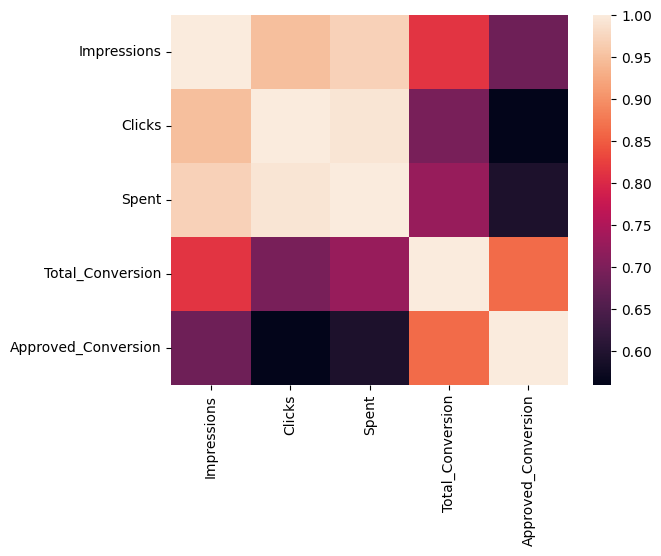

In [7]:
import seaborn as sns

sns.heatmap(
    df.select(
        "Impressions", "Clicks", "Spent", "Total_Conversion", "Approved_Conversion"
    )
    .toPandas()
    .corr()
)

It is clearly see that Spent, Clicks, Impressions are highly correlated with each other, the same goes for Total_Conversion and Approved Conversion

## Create a temp view for this session

In [8]:
df.select(
    "ad_id",
    "xyz_campaign_id",
    "fb_campaign_id",
    "age",
    "gender",
    "interest",
    "Impressions",
    "Clicks",
    "Spent",
    "Total_Conversion",
    "Approved_Conversion",
).createOrReplaceTempView("df")

## Functions

In [9]:
def uni_eda(
    feat, ftype, scale=None, prob=False, agg="count", palette=None, font_scale=1
):
    spark.sql("SELECT COUNT(DISTINCT {}) FROM df".format(feat)).show()
    spark.sql("SELECT DISTINCT {} FROM df".format(feat)).show()

    spark.sql(
        "SELECT {0},count(*) \
            FROM df \
            GROUP BY {0}".format(
            feat
        )
    ).show()

    spark.sql(
        "SELECT {0}, {1}(Impressions) Impressions, \
            {1}(Clicks) Clicks, \
            {1}(Spent) Spent, \
            {1}(Total_conversion) Total_conversion, \
            {1}(Approved_conversion) Approved_conversion \
            FROM df \
            GROUP BY {0}".format(
            feat, agg
        )
    ).show()
    sns.set(font_scale=font_scale)
    sns.set_style("whitegrid")
    sns.barplot(
        x=feat,
        y="count",
        data=spark.sql(
            "SELECT {0},count(*) count \
            FROM df \
            GROUP BY {0}".format(
                feat
            )
        ).toPandas(),
        palette=palette,
    )
    plt.savefig("{}_uni.png".format(feat))

    # sns.set(font_scale = 2)
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(50, 10))
    i = 0
    for col in [
        "Impressions",
        "Clicks",
        "Spent",
        "Total_Conversion",
        "Approved_Conversion",
    ]:
        sns.set_style("whitegrid")
        sns.barplot(
            x=feat,
            y=col,
            data=spark.sql(
                "SELECT {0}, {1}(Impressions) Impressions, \
                {1}(Clicks) Clicks, \
                {1}(Spent) Spent, \
                {1}(Total_Conversion) Total_Conversion, \
                {1}(Approved_Conversion) Approved_Conversion \
                FROM df \
                GROUP BY {0}".format(
                    feat, agg
                )
            ).toPandas(),
            ax=axes[i],
        )
        if scale:
            axes[i].set_yscale(scale)
        i += 1
    sns.despine()


def var2(feat1, feat2, scale=None, agg="avg"):
    spark.sql(
        "SELECT {0}, {1}, \
                    {2}(Impressions) Impressions, \
                    {2}(Clicks) Clicks, \
                    {2}(Spent) Spent, \
                    {2}(Total_Conversion) Total_Conversion, \
                    {2}(Approved_Conversion) Approved_Conversion \
                    FROM df \
                    GROUP BY {0}, {1}".format(
            feat1, feat2, agg
        )
    ).show()
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(100, 20))
    i = 0
    for col in [
        "Impressions",
        "Clicks",
        "Spent",
        "Total_Conversion",
        "Approved_Conversion",
    ]:
        sns.barplot(
            x=feat1,
            y=col,
            hue=feat2,
            data=spark.sql(
                "SELECT {0}, {1}, \
                        {2}(Impressions) Impressions, \
                        {2}(Clicks) Clicks, \
                        {2}(Spent) Spent, \
                        {2}(Total_Conversion) Total_Conversion, \
                        {2}(Approved_Conversion) Approved_Conversion \
                        FROM df \
                        GROUP BY {0}, {1}".format(
                    feat1, feat2, agg
                )
            ).toPandas(),
            ax=axes[i],
        )
        if scale:
            axes[i].set_yscale("log")
        axes[i].set_ylabel(col, fontsize=40)
        axes[i].set_xlabel(feat1, fontsize=40)
        axes[i].legend(fontsize=40)
        i += 1

## Categorical Variables

### Campaign

+-------------------------------+
|count(DISTINCT xyz_campaign_id)|
+-------------------------------+
|                              3|
+-------------------------------+

+---------------+
|xyz_campaign_id|
+---------------+
|            916|
|            936|
|           1178|
+---------------+

+---------------+--------+
|xyz_campaign_id|count(1)|
+---------------+--------+
|            916|      54|
|            936|     464|
|           1178|     625|
+---------------+--------+

+---------------+-----------+------+-----+----------------+-------------------+
|xyz_campaign_id|Impressions|Clicks|Spent|Total_conversion|Approved_conversion|
+---------------+-----------+------+-----+----------------+-------------------+
|            916|         54|    54|   54|              54|                 54|
|            936|        464|   464|  464|             464|                464|
|           1178|        625|   625|  625|             625|                625|
+---------------+-----------+---

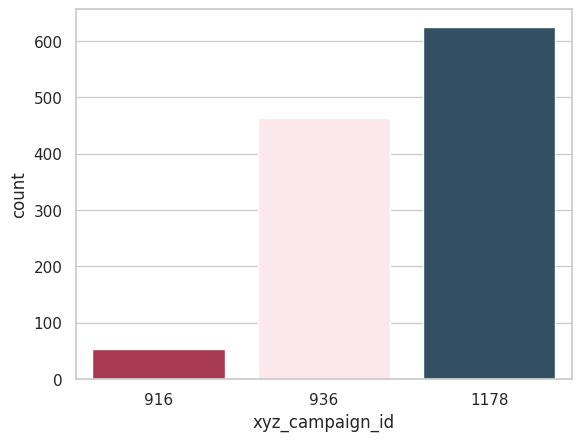

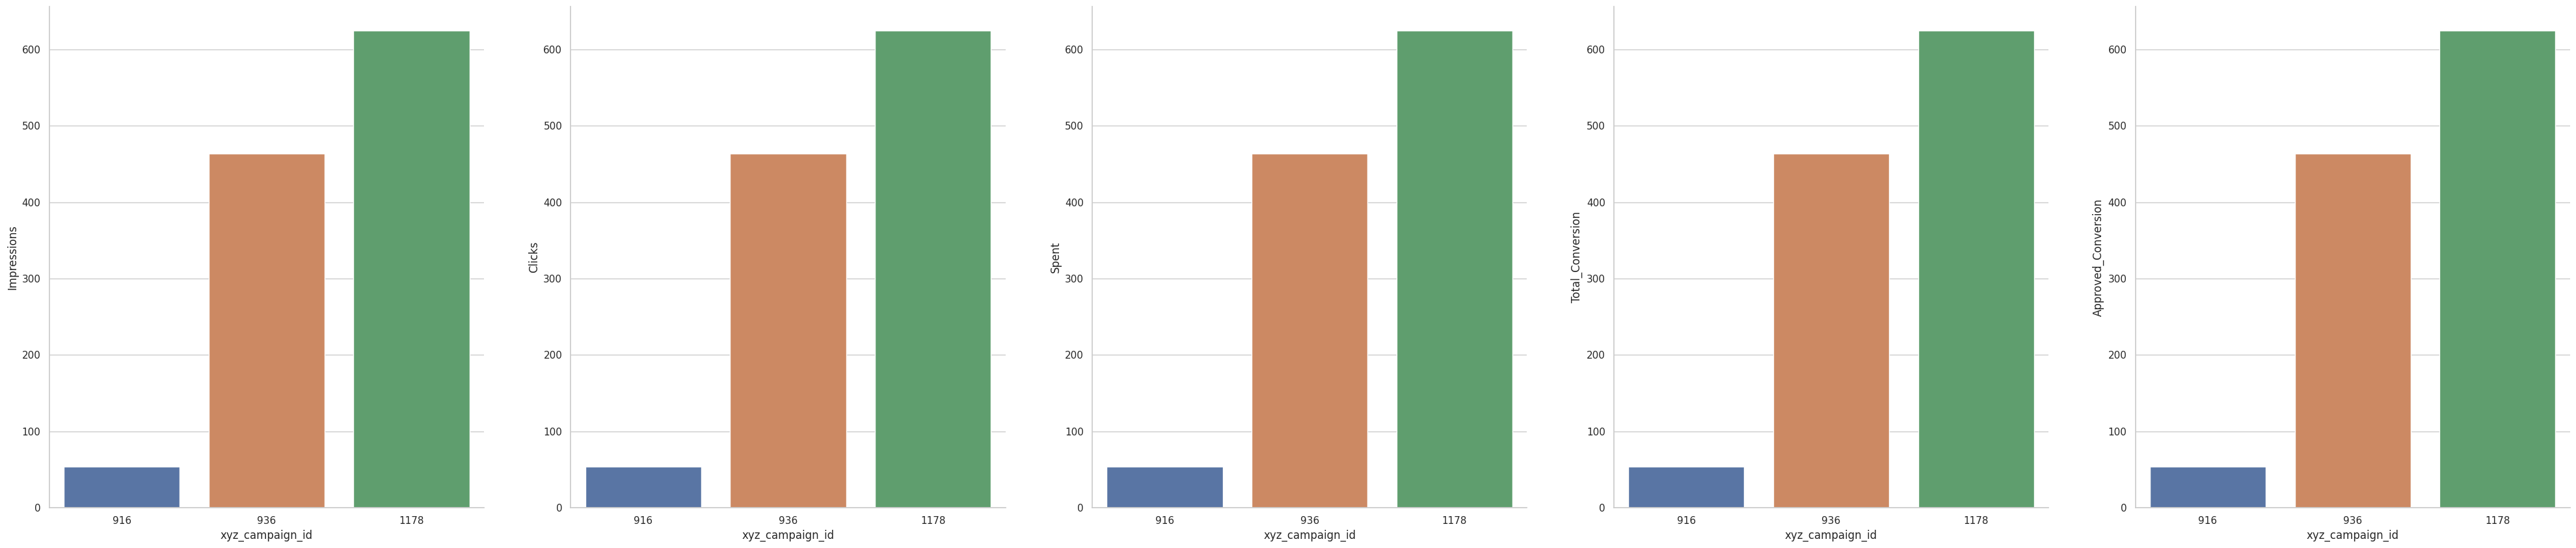

In [10]:
import matplotlib.pyplot as plt

uni_eda("xyz_campaign_id", "cat", agg='count', palette=['#BB2649','#FFE4EA','#2B526B'])

+---------------+-----+------------------+------------------+------------------+------------------+-------------------+
|xyz_campaign_id|  age|       Impressions|            Clicks|             Spent|  Total_Conversion|Approved_Conversion|
+---------------+-----+------------------+------------------+------------------+------------------+-------------------+
|           1178|40-44|297199.48062015505| 57.44961240310077|  86.2210851221938| 3.356589147286822| 1.0930232558139534|
|            936|40-44|          16047.96|4.1466666666666665| 6.005333330333332|1.1066666666666667| 0.3333333333333333|
|            936|45-49| 39970.82692307692|10.692307692307692|   16.039423051625|1.2596153846153846|0.34615384615384615|
|            916|45-49|11742.857142857143|3.5714285714285716| 4.847142883428572|               1.0|0.42857142857142855|
|           1178|45-49| 401984.4054054054| 85.91216216216216|128.70702702095272| 3.689189189189189| 1.1418918918918919|
|           1178|35-39|278312.1972789115

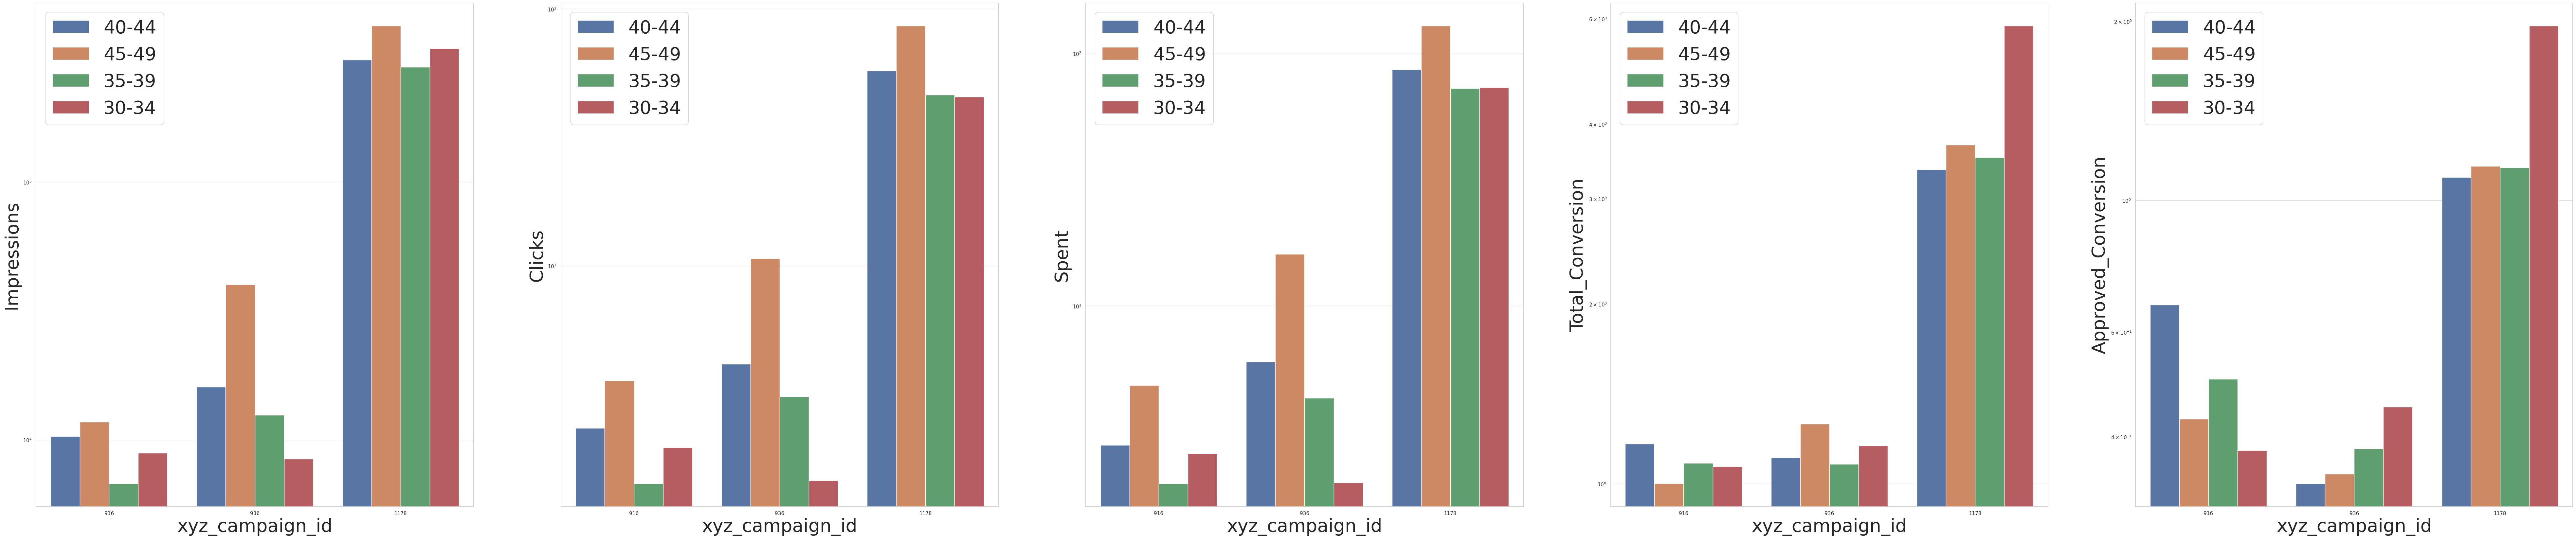

In [11]:
var2('xyz_campaign_id', 'age', scale='log')

+---------------+------+------------------+------------------+------------------+------------------+-------------------+
|xyz_campaign_id|gender|       Impressions|            Clicks|             Spent|  Total_Conversion|Approved_Conversion|
+---------------+------+------------------+------------------+------------------+------------------+-------------------+
|            916|     F|10372.684210526315| 2.736842105263158| 3.676315796684211|1.0526315789473684|0.42105263157894735|
|           1178|     F| 392665.0724637681| 80.40942028985508|116.13192016176082|4.7898550724637685| 1.4166666666666667|
|            936|     M| 8836.447115384615|            1.6875| 2.466394232447115|1.1298076923076923| 0.4182692307692308|
|           1178|     M|276355.74785100284| 39.75644699140401| 67.64968479646991| 3.859598853868195| 1.3782234957020056|
|            936|     F|     24571.1171875|        6.37890625|  9.29828124447265|         1.1796875|              0.375|
|            916|     M| 8166.97

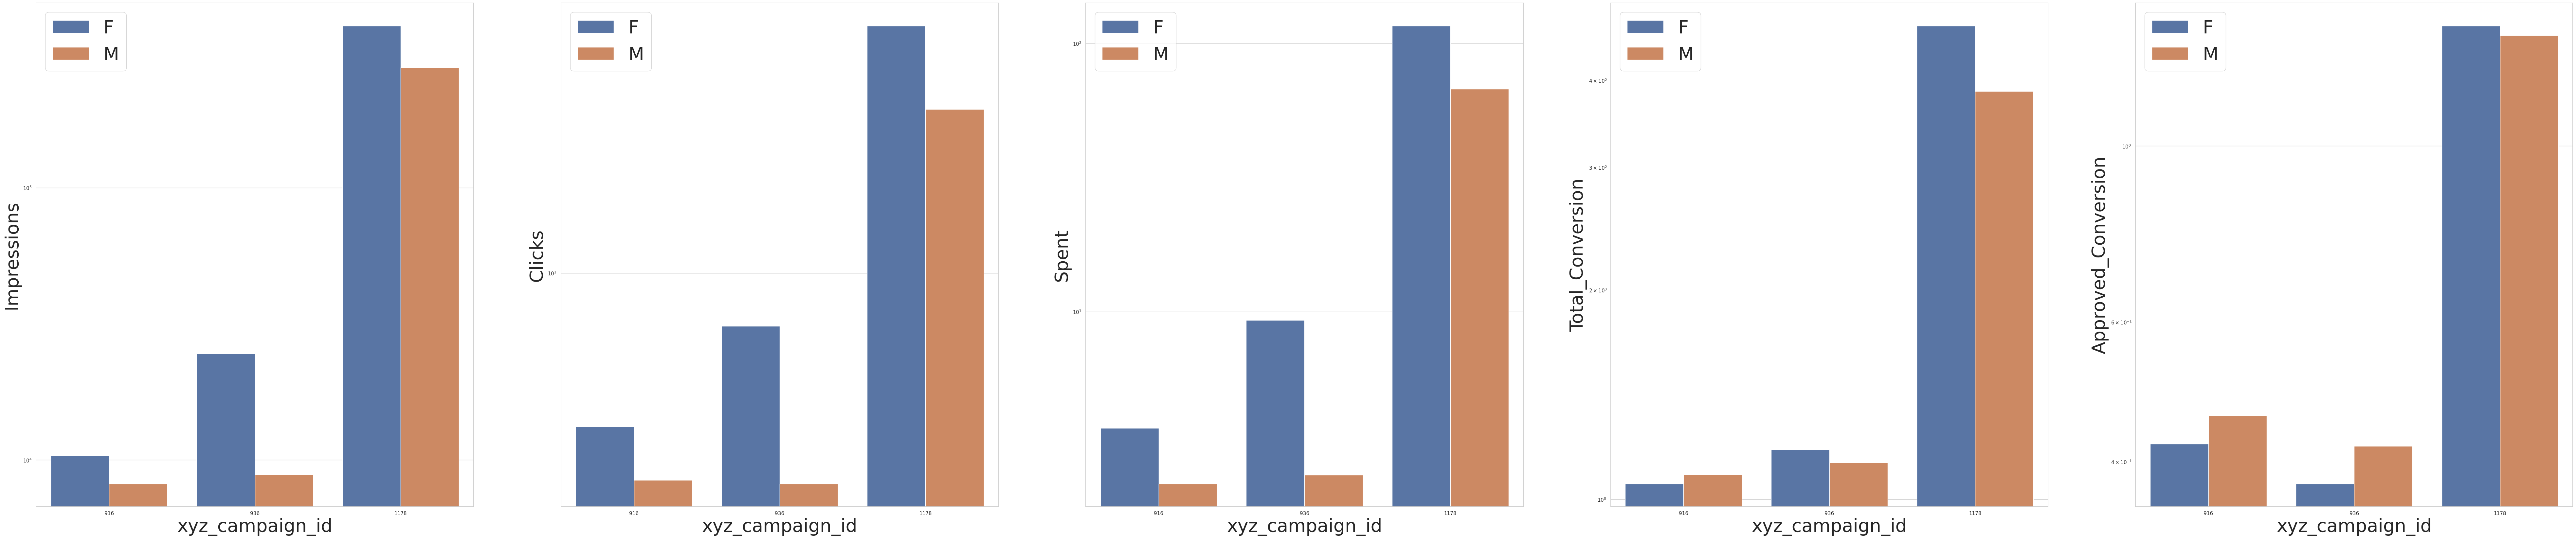

In [12]:
var2('xyz_campaign_id', 'gender', scale='log')

+---------------+--------+------------------+------------------+------------------+------------------+-------------------+
|xyz_campaign_id|interest|       Impressions|            Clicks|             Spent|  Total_Conversion|Approved_Conversion|
+---------------+--------+------------------+------------------+------------------+------------------+-------------------+
|           1178|      65|148549.81818181818|31.181818181818183| 45.21454554500001| 2.272727272727273| 1.2727272727272727|
|            936|      65|12925.714285714286|3.4285714285714284| 5.384285671428572|               1.0| 0.7142857142857143|
|            916|      65|           13019.0|               5.0|       6.960000038|               1.0|                0.0|
|            936|      31|            3397.0|              0.75|    1.096250027375|             1.125|              0.625|
|           1178|     114|          213232.8|              38.2|     56.5239996196|               2.4|                0.8|
|            936

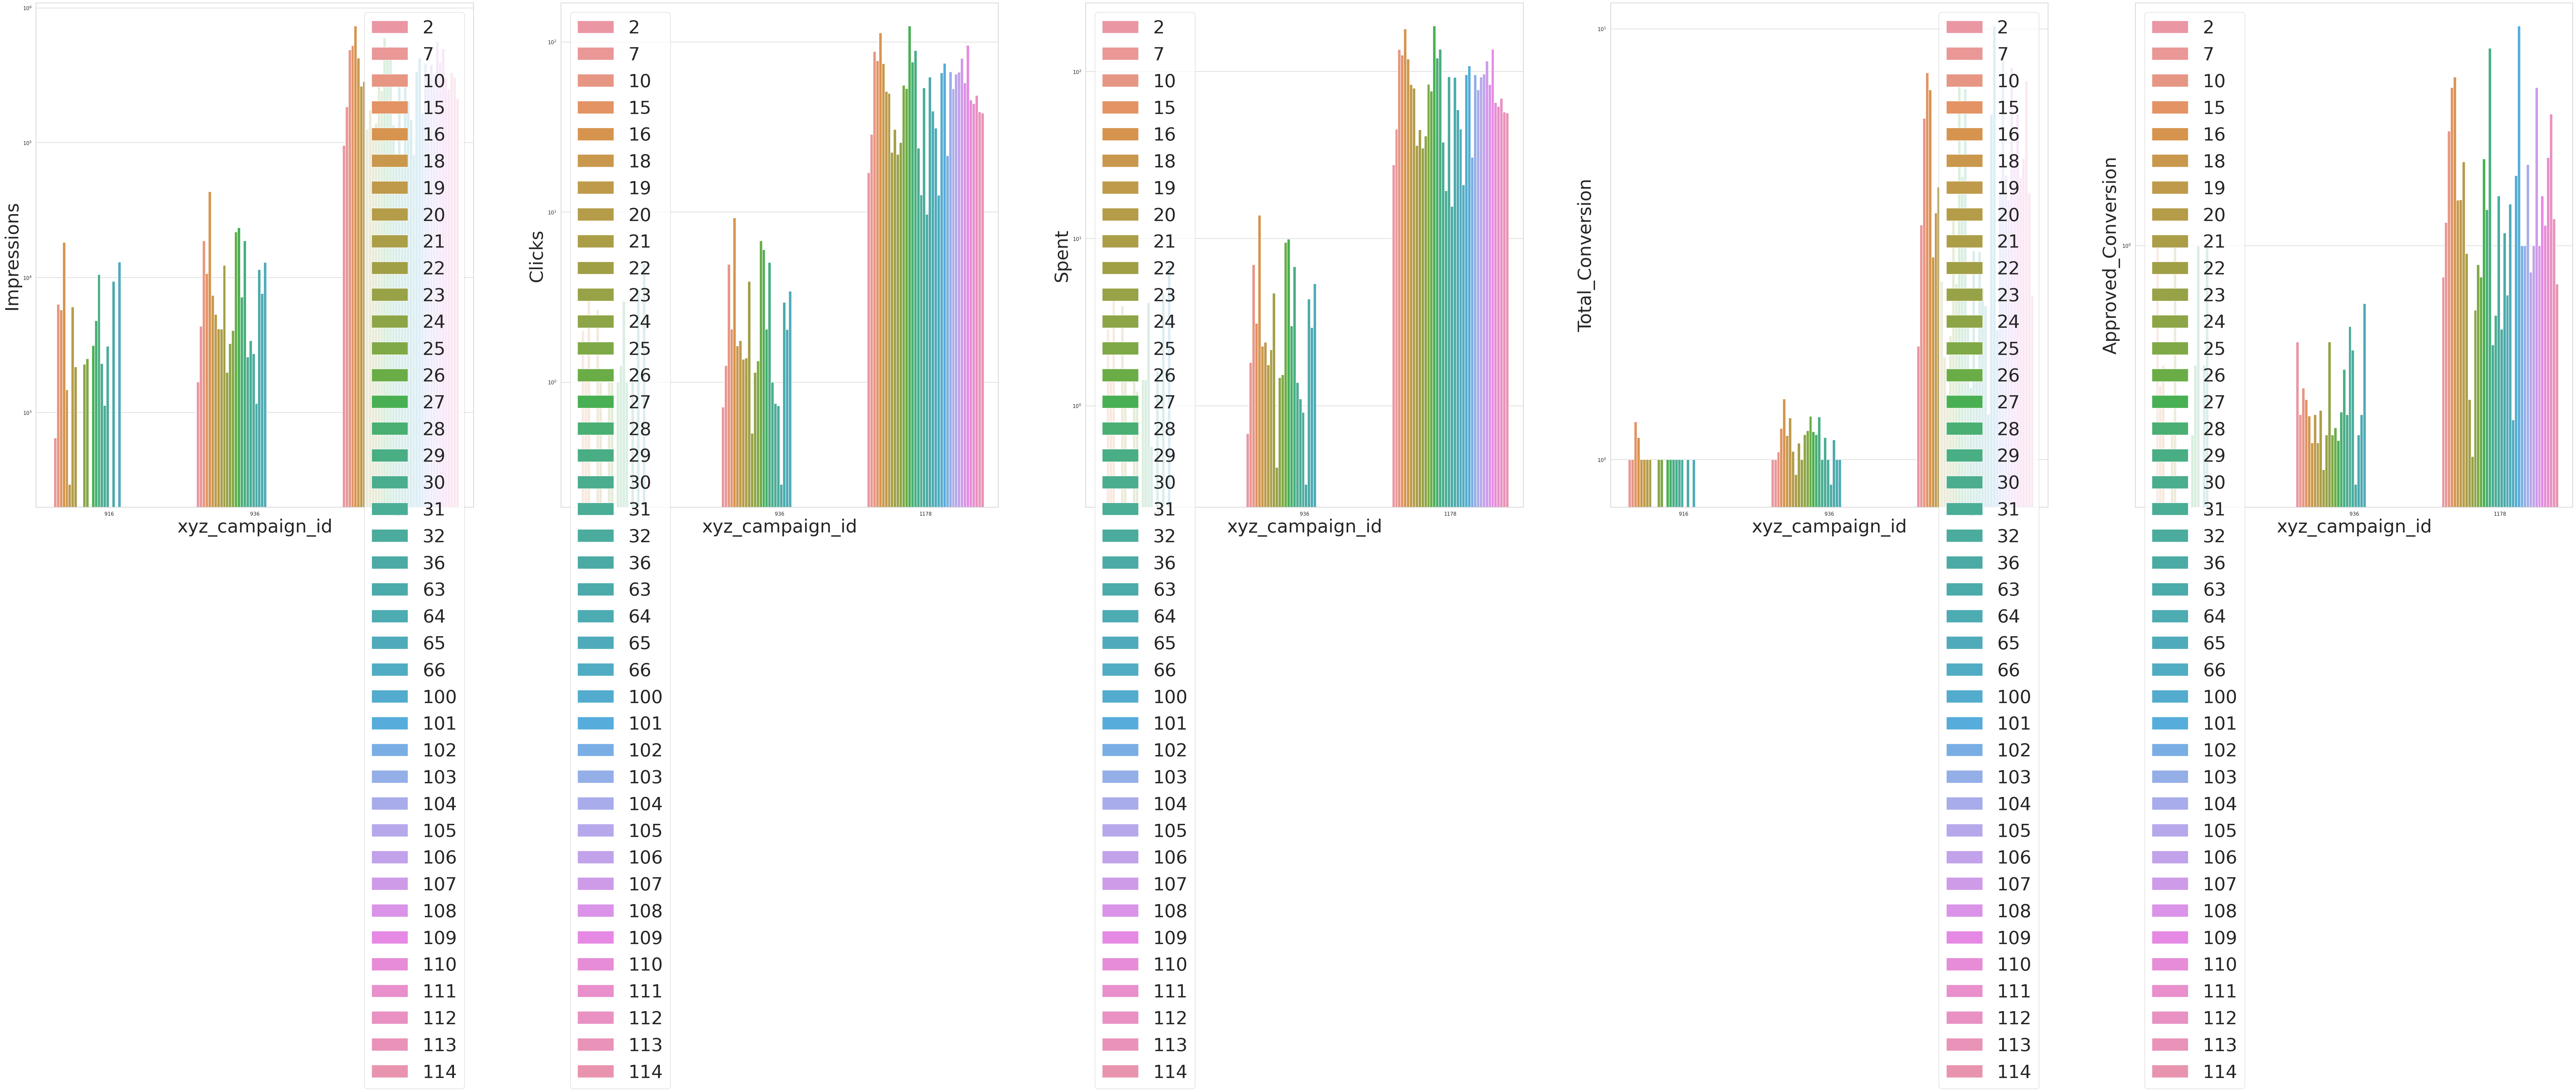

In [13]:
var2('xyz_campaign_id', 'interest', scale='log')

### Age

+-------------------+
|count(DISTINCT age)|
+-------------------+
|                  4|
+-------------------+

+-----+
|  age|
+-----+
|30-34|
|35-39|
|45-49|
|40-44|
+-----+

+-----+--------+
|  age|count(1)|
+-----+--------+
|30-34|     426|
|35-39|     248|
|45-49|     259|
|40-44|     210|
+-----+--------+

+-----+-----------+------+-----+----------------+-------------------+
|  age|Impressions|Clicks|Spent|Total_conversion|Approved_conversion|
+-----+-----------+------+-----+----------------+-------------------+
|30-34|        426|   426|  426|             426|                426|
|35-39|        248|   248|  248|             248|                248|
|45-49|        259|   259|  259|             259|                259|
|40-44|        210|   210|  210|             210|                210|
+-----+-----------+------+-----+----------------+-------------------+



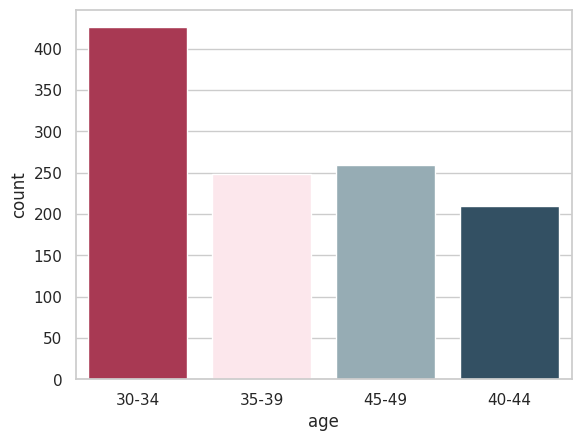

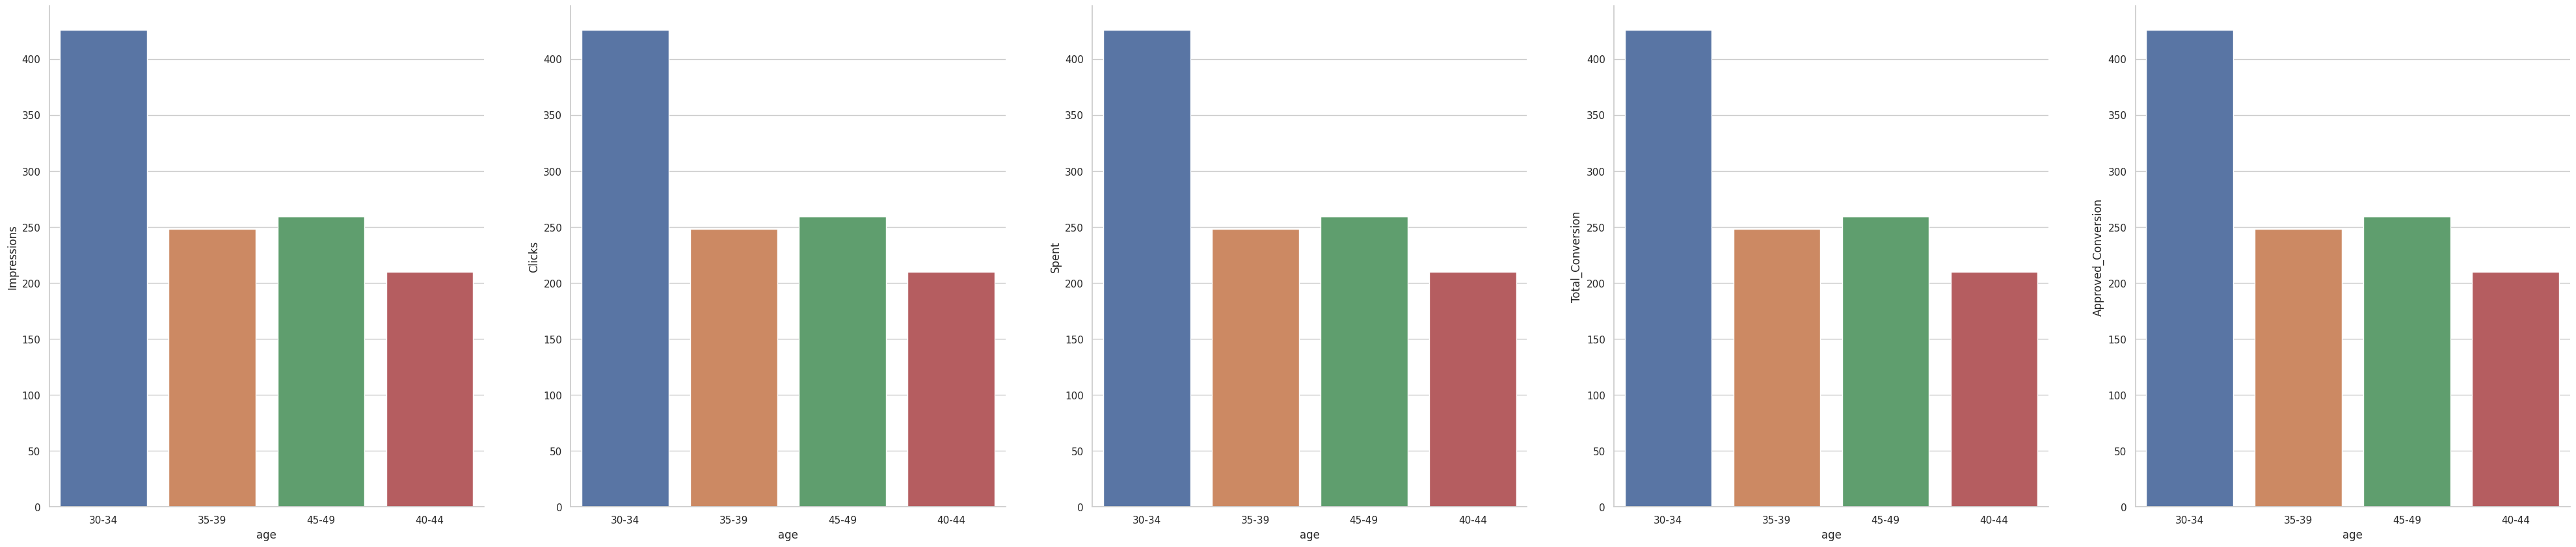

In [14]:
uni_eda("age", "cat", agg='count', palette=['#BB2649','#FFE4EA', '#91AEB9' ,'#2B526B'])

+-------------------+
|count(DISTINCT age)|
+-------------------+
|                  4|
+-------------------+

+-----+
|  age|
+-----+
|30-34|
|35-39|
|45-49|
|40-44|
+-----+

+-----+--------+
|  age|count(1)|
+-----+--------+
|30-34|     426|
|35-39|     248|
|45-49|     259|
|40-44|     210|
+-----+--------+

+-----+------------------+------------------+------------------+------------------+-------------------+
|  age|       Impressions|            Clicks|             Spent|  Total_conversion|Approved_conversion|
+-----+------------------+------------------+------------------+------------------+-------------------+
|30-34|159608.02582159624|22.260563380281692|35.803755836568065| 3.359154929577465|   1.15962441314554|
|35-39|169776.79032258064| 28.60483870967742| 44.80818546102822| 2.524193548387097| 0.8346774193548387|
|45-49| 246072.8108108108| 53.48262548262548| 80.11841697549805| 2.640926640926641|  0.803088803088803|
|40-44| 188591.9380952381|36.838095238095235| 55.18919038494284

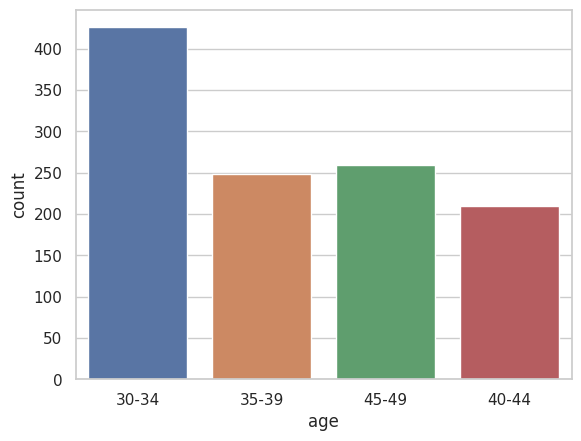

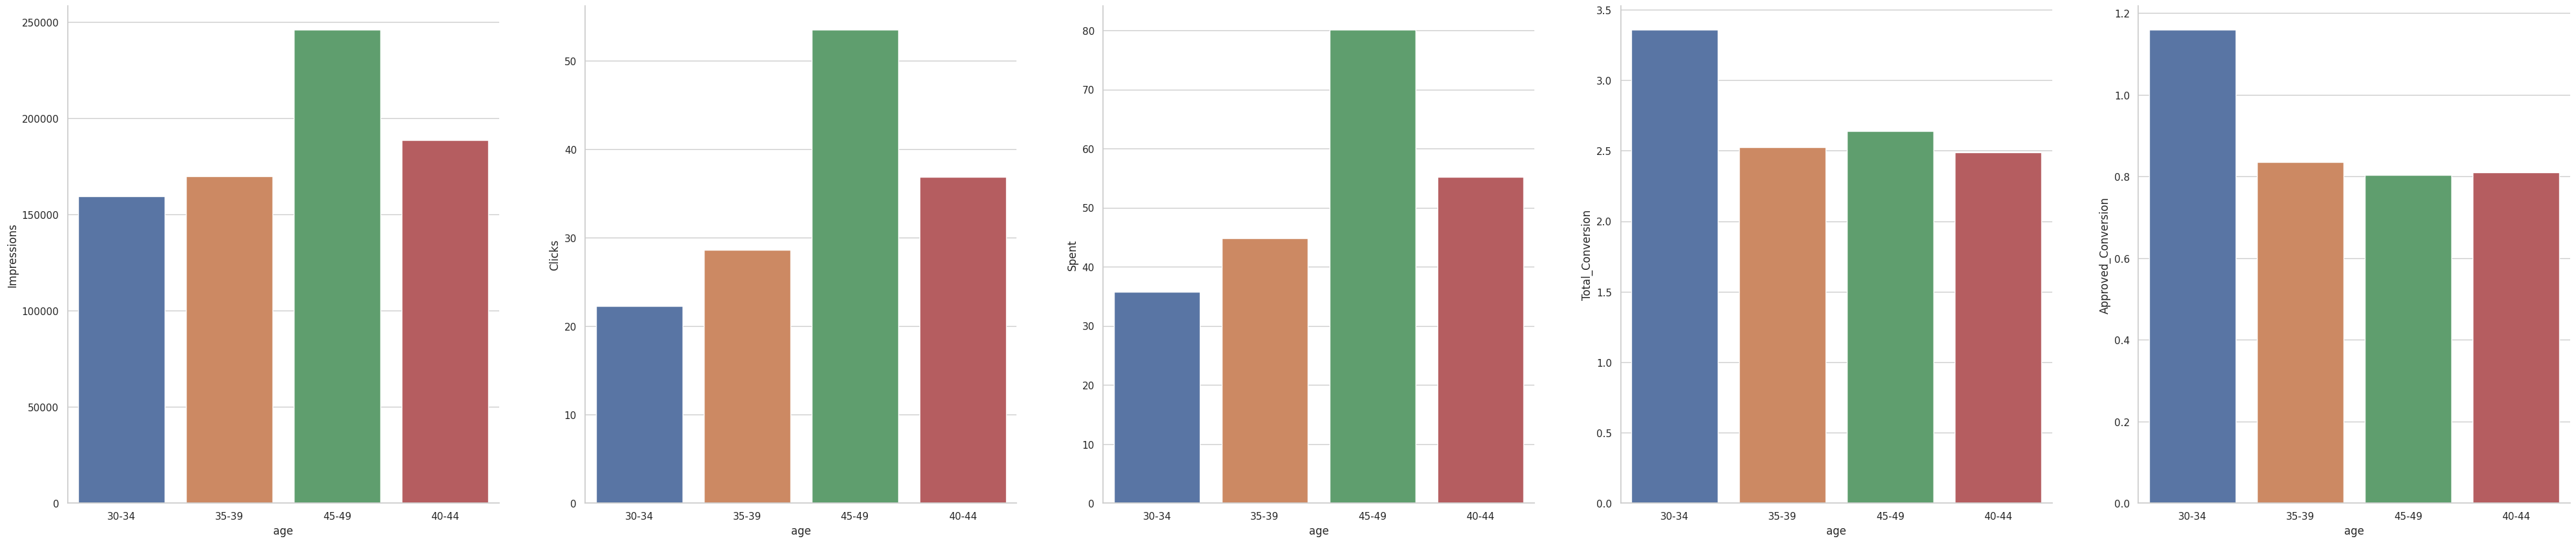

In [15]:
uni_eda("age", "cat", agg='avg')

The age 45-49 is spent on a lot, got a lot of impressions and clicks but less enquirement and sales.
In contrast, the group 30-34 have highest conversions though spent amount is less than 45-49

+-----+---------------+------------------+------------------+------------------+------------------+-------------------+
|  age|xyz_campaign_id|       Impressions|            Clicks|             Spent|  Total_Conversion|Approved_Conversion|
+-----+---------------+------------------+------------------+------------------+------------------+-------------------+
|35-39|            936|12490.730337078652|3.0898876404494384|4.3082022635842705|1.0786516853932584|0.38202247191011235|
|30-34|            916| 8885.241379310344|1.9655172413793103|2.5975862133793104|1.0689655172413792| 0.3793103448275862|
|30-34|            936| 8448.719387755102|1.4591836734693877|1.9971428588316327|1.1581632653061225| 0.4489795918367347|
|40-44|           1178|297199.48062015505| 57.44961240310077|  86.2210851221938| 3.356589147286822| 1.0930232558139534|
|40-44|            916|           10329.5|2.3333333333333335|2.8016667166666664|1.1666666666666667| 0.6666666666666666|
|45-49|           1178| 401984.405405405

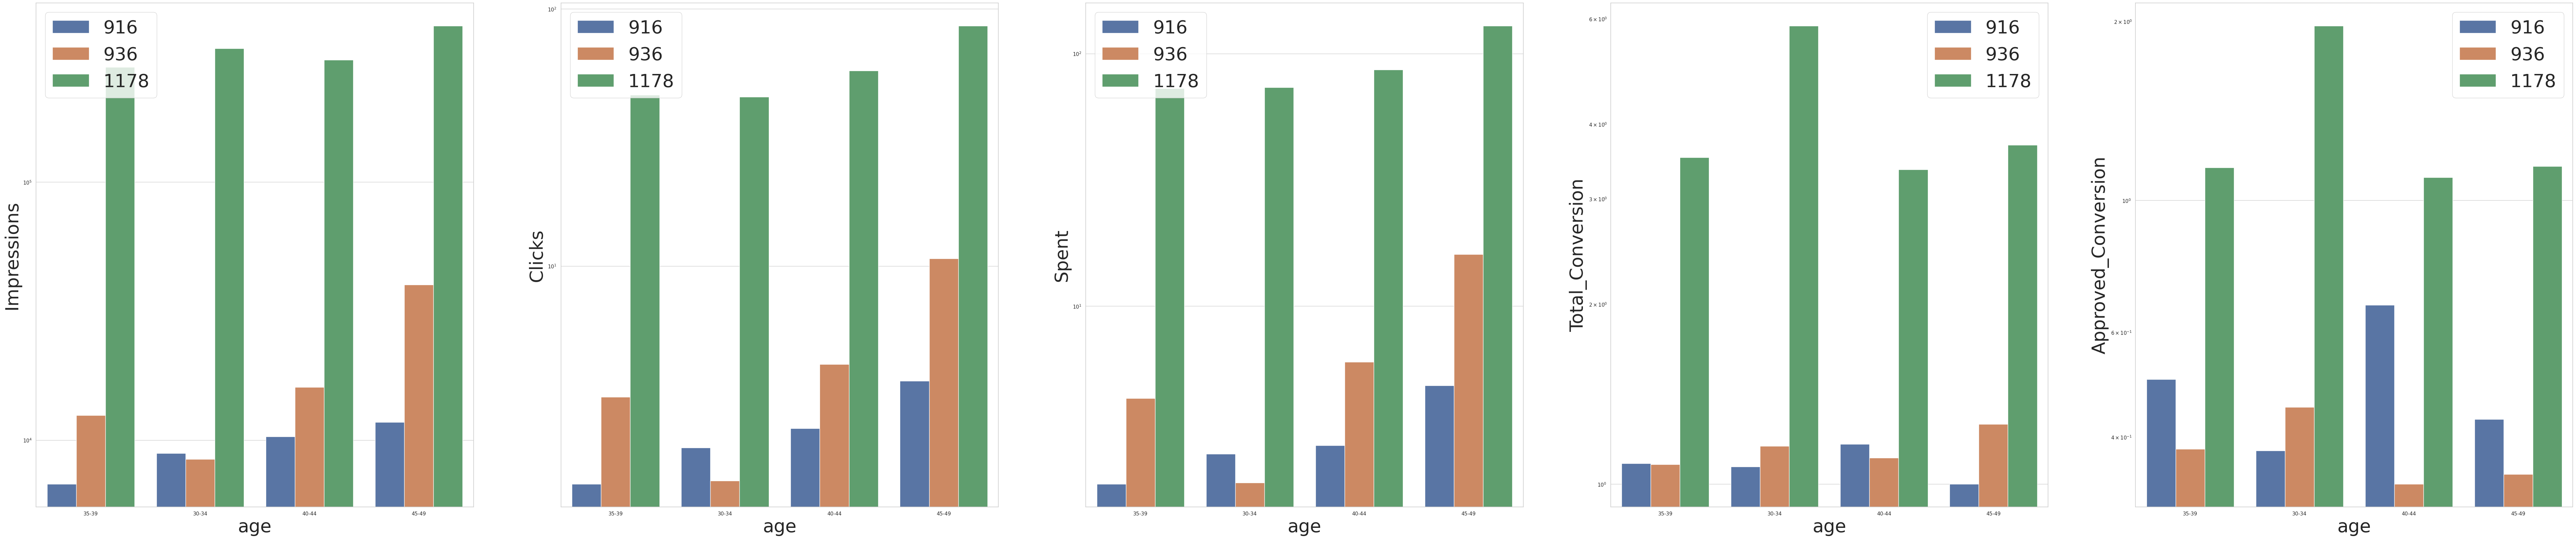

In [16]:
var2('age', 'xyz_campaign_id', scale='log')

+-----+------+------------------+------------------+------------------+------------------+-------------------+
|  age|gender|       Impressions|            Clicks|             Spent|  Total_Conversion|Approved_Conversion|
+-----+------+------------------+------------------+------------------+------------------+-------------------+
|35-39|     F|196692.70642201835|38.174311926605505| 55.60871552134863|2.7889908256880735| 0.8715596330275229|
|45-49|     M|208903.03305785125| 36.45454545454545| 60.47487606509918| 2.355371900826446| 0.7933884297520661|
|35-39|     M|148670.06474820143|21.100719424460433| 36.33870505401439| 2.316546762589928| 0.8057553956834532|
|45-49|     F| 278663.7028985507| 68.41304347826087| 97.34210139693481| 2.891304347826087| 0.8115942028985508|
|40-44|     F|218655.84112149532| 48.38317757009346| 69.12691573492526|3.0093457943925235| 0.8691588785046729|
|40-44|     M|157360.50485436892|24.844660194174757| 40.71019414758252|1.9514563106796117| 0.7475728155339806|
|

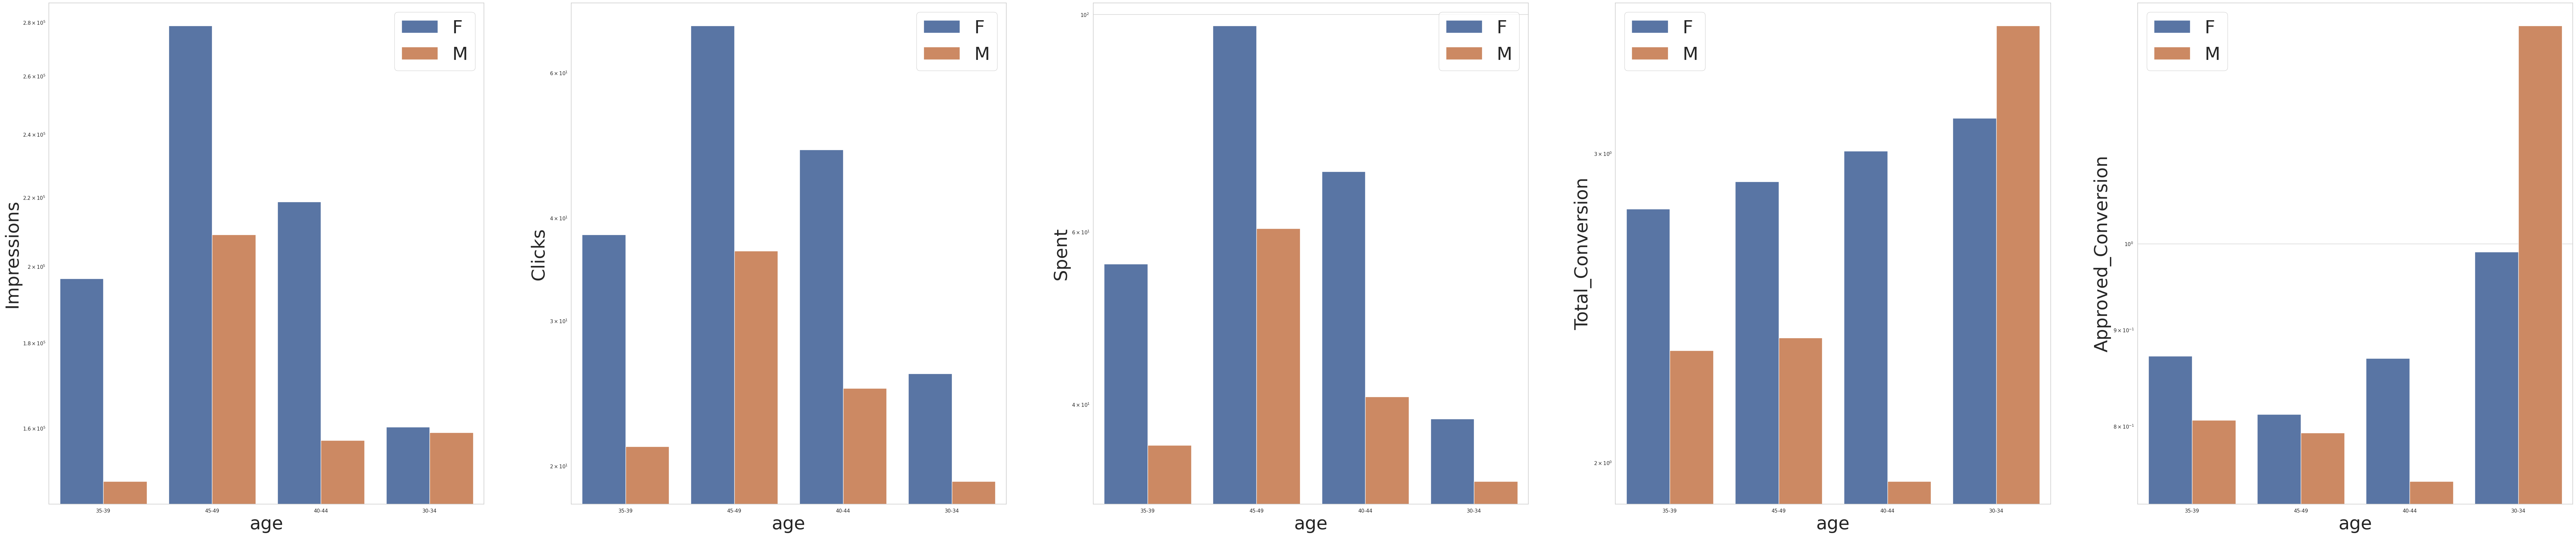

In [17]:
var2('age', 'gender', scale='log')

+----------------------+
|count(DISTINCT gender)|
+----------------------+
|                     2|
+----------------------+

+------+
|gender|
+------+
|     F|
|     M|
+------+

+------+--------+
|gender|count(1)|
+------+--------+
|     F|     551|
|     M|     592|
+------+--------+

+------+-----------+------+-----+----------------+-------------------+
|gender|Impressions|Clicks|Spent|Total_conversion|Approved_conversion|
+------+-----------+------+-----+----------------+-------------------+
|     F|        551|   551|  551|             551|                551|
|     M|        592|   592|  592|             592|                592|
+------+-----------+------+-----+----------------+-------------------+



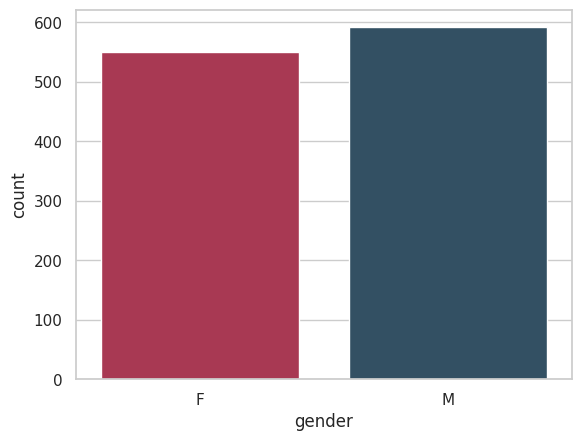

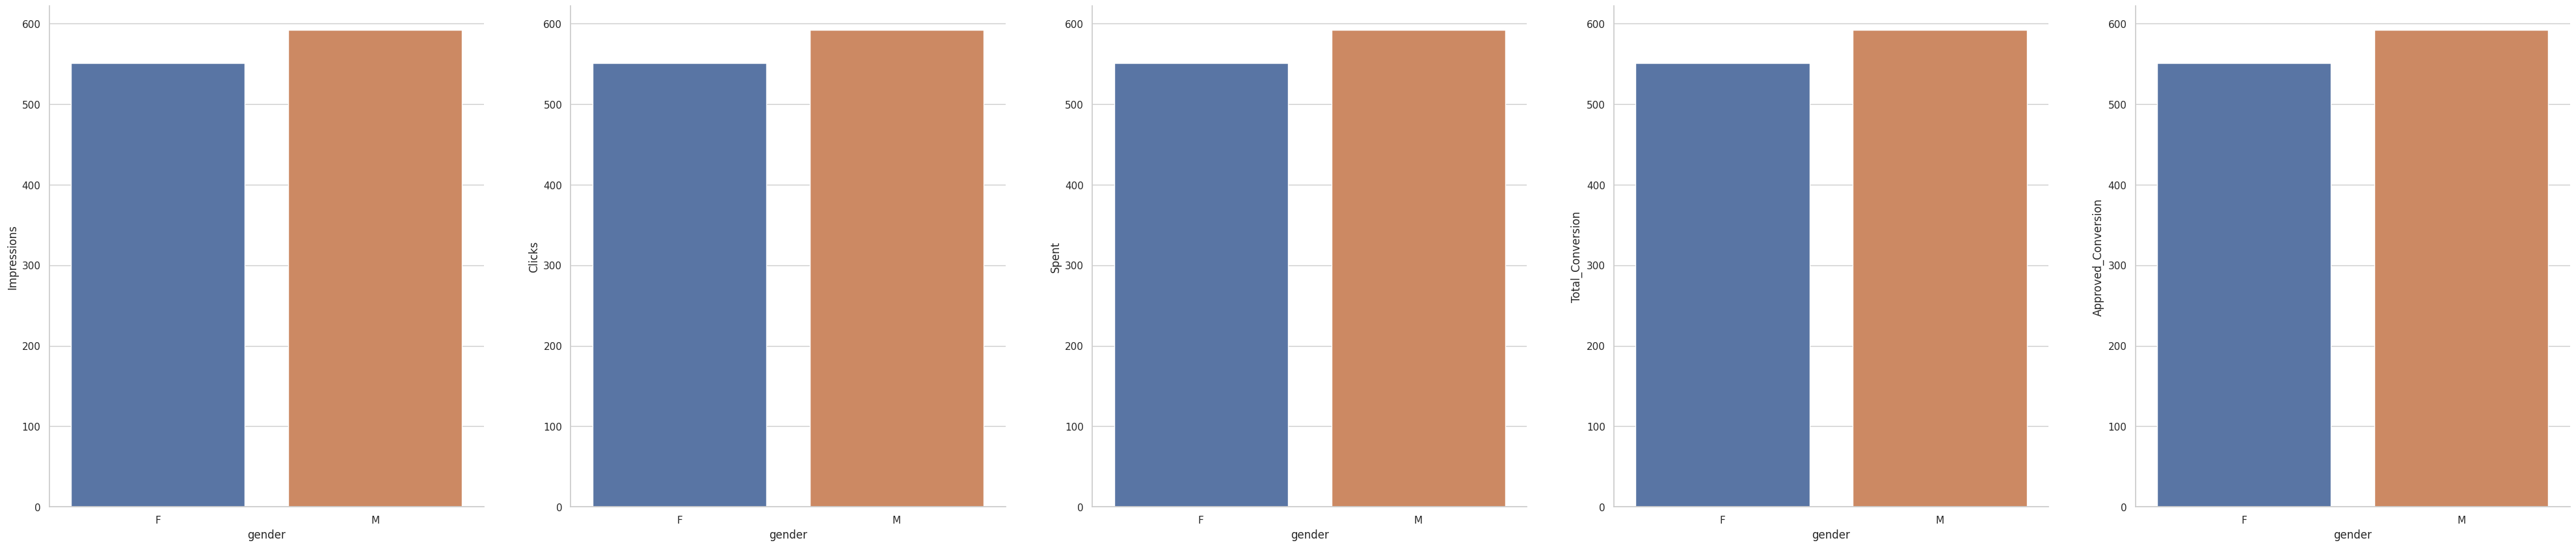

In [18]:
uni_eda("gender", "cat", agg='count', palette=['#BB2649','#2B526B'])

### Gender

+----------------------+
|count(DISTINCT gender)|
+----------------------+
|                     2|
+----------------------+

+------+
|gender|
+------+
|     F|
|     M|
+------+

+------+--------+
|gender|count(1)|
+------+--------+
|     F|     551|
|     M|     592|
+------+--------+

+------+-----------+------+-----+----------------+-------------------+
|gender|Impressions|Clicks|Spent|Total_conversion|Approved_conversion|
+------+-----------+------+-----+----------------+-------------------+
|     F|        551|   551|  551|             551|                551|
|     M|        592|   592|  592|             592|                592|
+------+-----------+------+-----+----------------+-------------------+



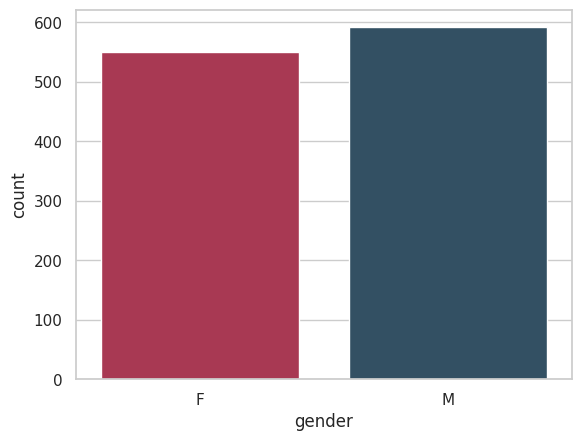

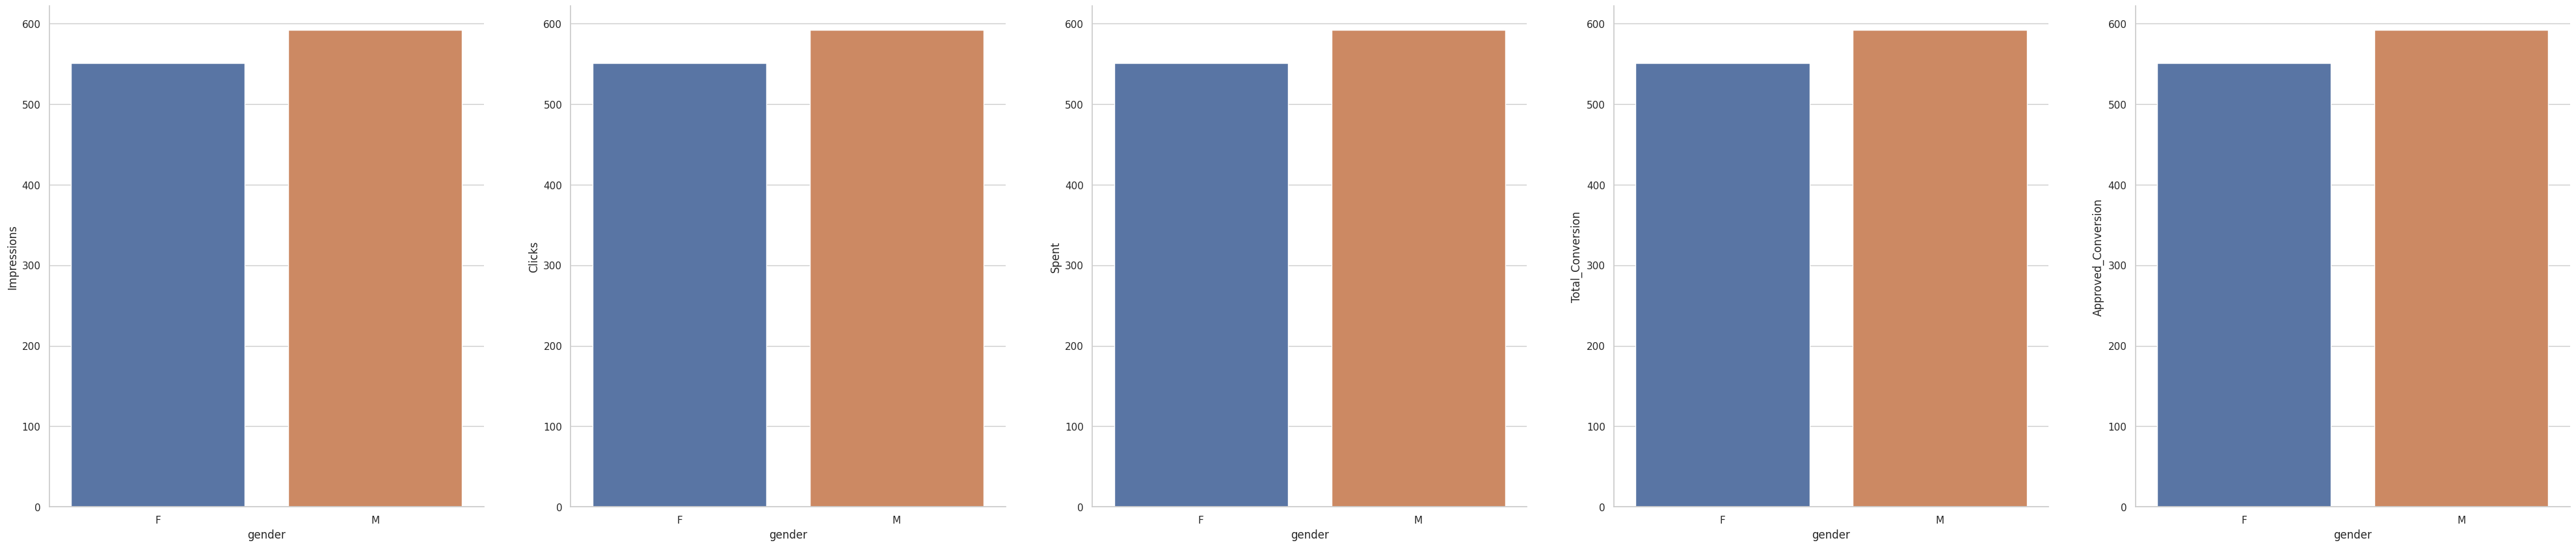

In [19]:
uni_eda("gender", "cat", agg='count', palette=['#BB2649','#2B526B'])

Although Female is invested in more, and they have higher impressions/clicks but Male tends to buy the product after clicks more.

+----------------------+
|count(DISTINCT gender)|
+----------------------+
|                     2|
+----------------------+

+------+
|gender|
+------+
|     F|
|     M|
+------+

+------+--------+
|gender|count(1)|
+------+--------+
|     F|     551|
|     M|     592|
+------+--------+

+------+------------------+------------------+-----------------+------------------+-------------------+
|gender|       Impressions|            Clicks|            Spent|  Total_conversion|Approved_conversion|
+------+------------------+------------------+-----------------+------------------+-------------------+
|     F| 208462.5172413793| 43.33575317604356| 62.6181850514846| 2.983666061705989| 0.8983666061705989|
|     M|166506.72466216216|24.133445945945947|40.88278715344088|2.7364864864864864| 0.9864864864864865|
+------+------------------+------------------+-----------------+------------------+-------------------+



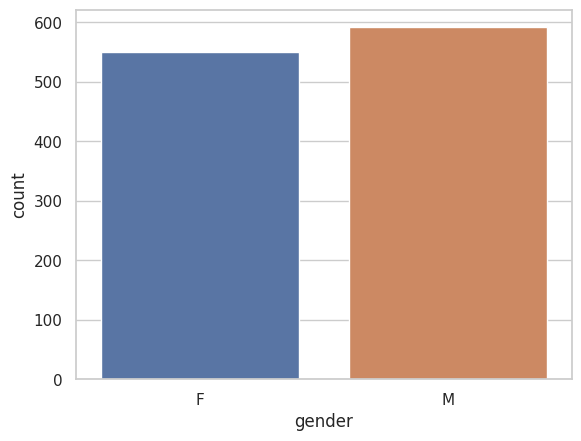

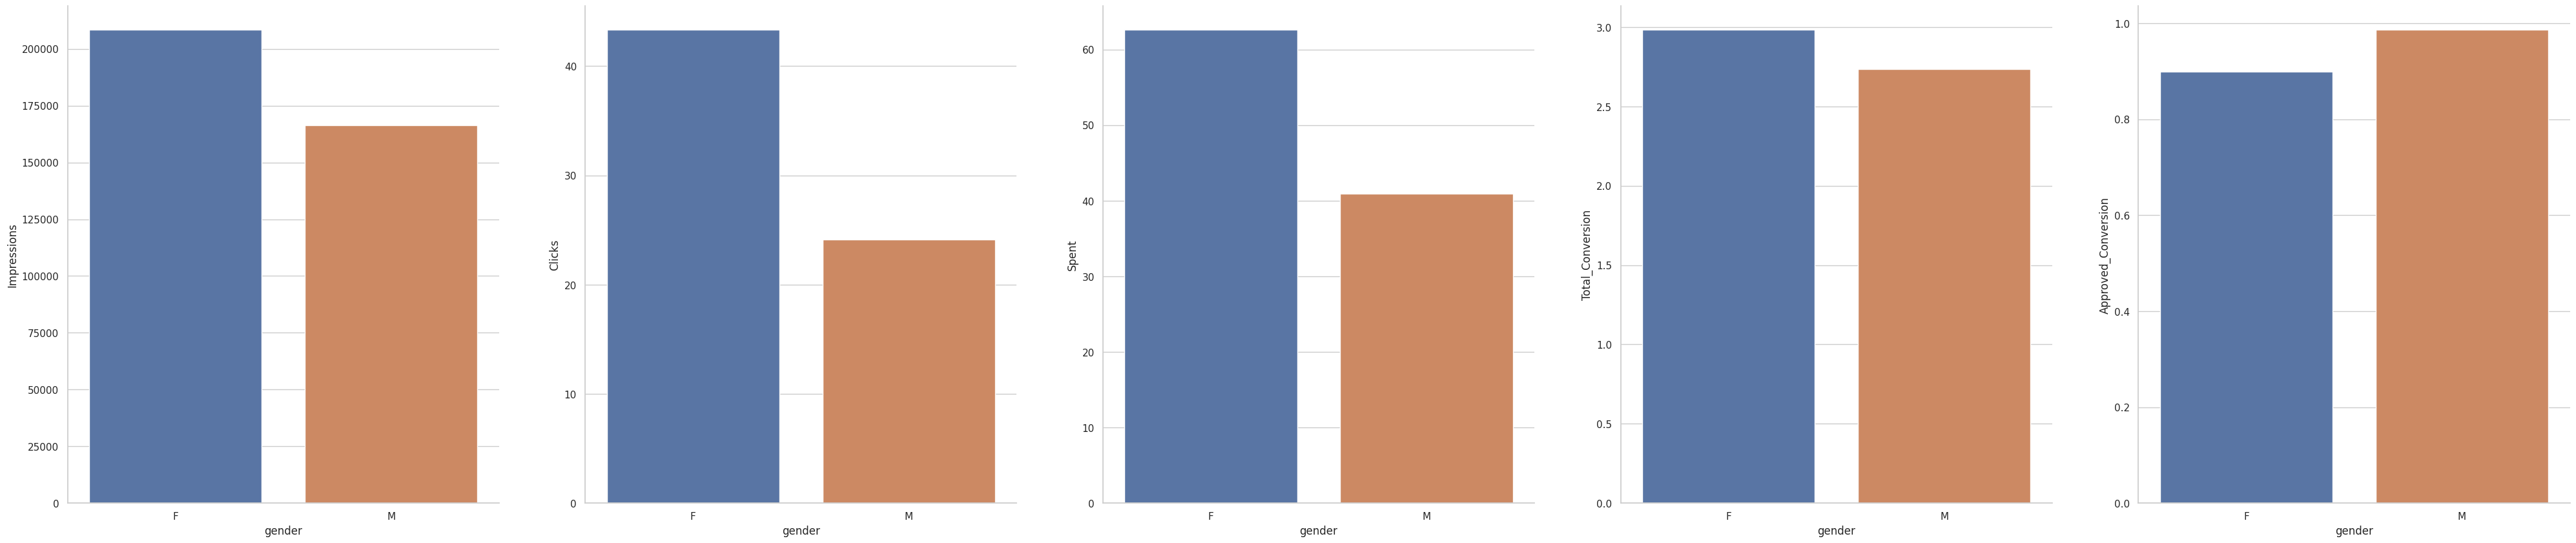

In [20]:
uni_eda("gender", "cat", agg='avg')

### Interest

+------------------------+
|count(DISTINCT interest)|
+------------------------+
|                      40|
+------------------------+

+--------+
|interest|
+--------+
|      31|
|      65|
|     108|
|     101|
|      28|
|      27|
|      26|
|     103|
|      22|
|     111|
|      16|
|      20|
|      19|
|      64|
|      15|
|     112|
|     107|
|     114|
|     100|
|      23|
+--------+
only showing top 20 rows

+--------+--------+
|interest|count(1)|
+--------+--------+
|      31|      25|
|      65|      19|
|     108|       7|
|     101|       7|
|      28|      51|
|      27|      60|
|      26|      41|
|     103|       5|
|      22|      33|
|     111|       6|
|      16|     140|
|      20|      49|
|      19|      32|
|      64|      48|
|      15|      51|
|     112|       7|
|     107|       8|
|     114|       5|
|     100|       6|
|      23|      23|
+--------+--------+
only showing top 20 rows

+--------+-----------+------+-----+----------------+----------------

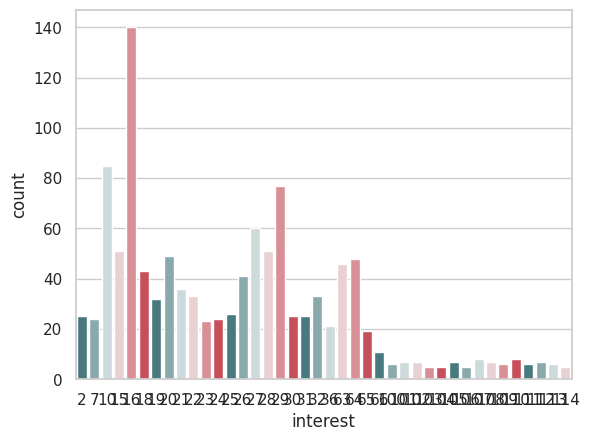

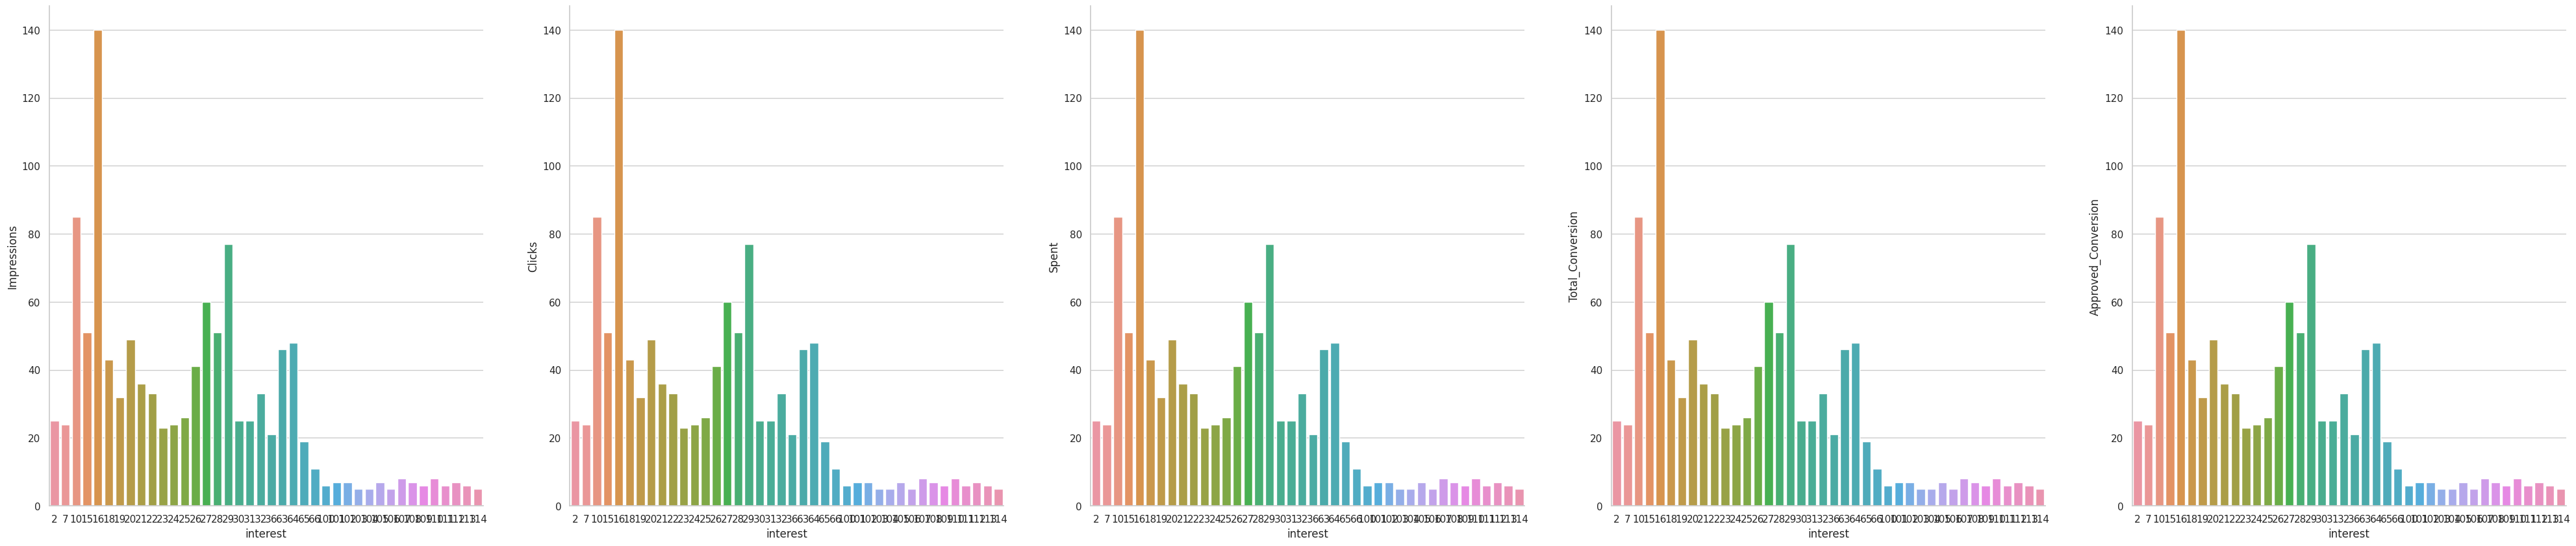

In [21]:
uni_eda("interest", "cat", agg='count', palette=sns.diverging_palette(203.5, 9.5))

It is worthnoting that the interest 100-114 is more focused on despite that their amount is less compare to other interests.

+------------------------+
|count(DISTINCT interest)|
+------------------------+
|                      40|
+------------------------+

+--------+
|interest|
+--------+
|      31|
|      65|
|     108|
|     101|
|      28|
|      27|
|      26|
|     103|
|      22|
|     111|
|      16|
|      20|
|      19|
|      64|
|      15|
|     112|
|     107|
|     114|
|     100|
|      23|
+--------+
only showing top 20 rows

+--------+--------+
|interest|count(1)|
+--------+--------+
|      31|      25|
|      65|      19|
|     108|       7|
|     101|       7|
|      28|      51|
|      27|      60|
|      26|      41|
|     103|       5|
|      22|      33|
|     111|       6|
|      16|     140|
|      20|      49|
|      19|      32|
|      64|      48|
|      15|      51|
|     112|       7|
|     107|       8|
|     114|       5|
|     100|       6|
|      23|      23|
+--------+--------+
only showing top 20 rows

+--------+------------------+------------------+------------------+-

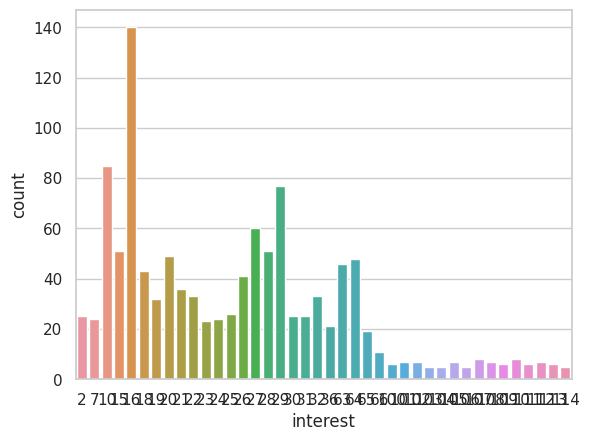

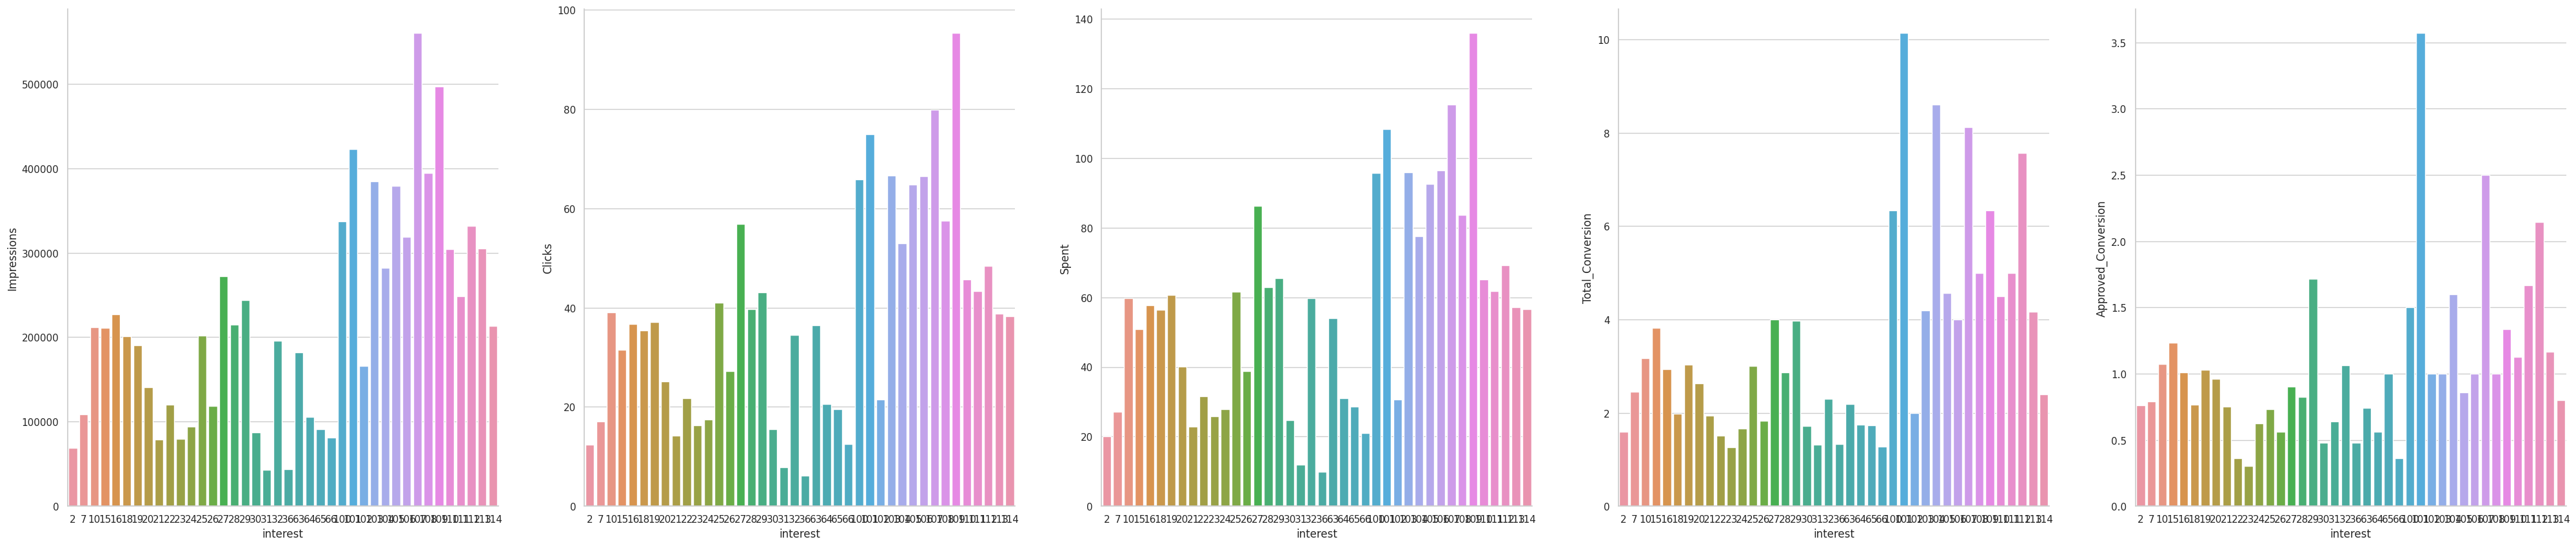

In [22]:
uni_eda("interest", "cat", agg='avg')

### Spent

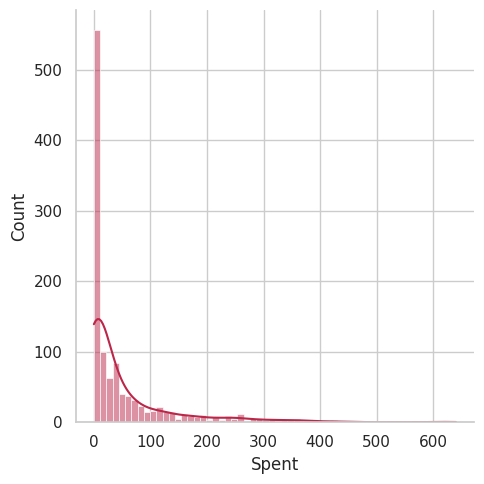

In [23]:
sns.set_style("whitegrid")
sns.displot(data=df.toPandas(), x="Spent", kde=True, rug=False, color="#BB2649")
plt.savefig("spent_uni.png")

## Correlogram

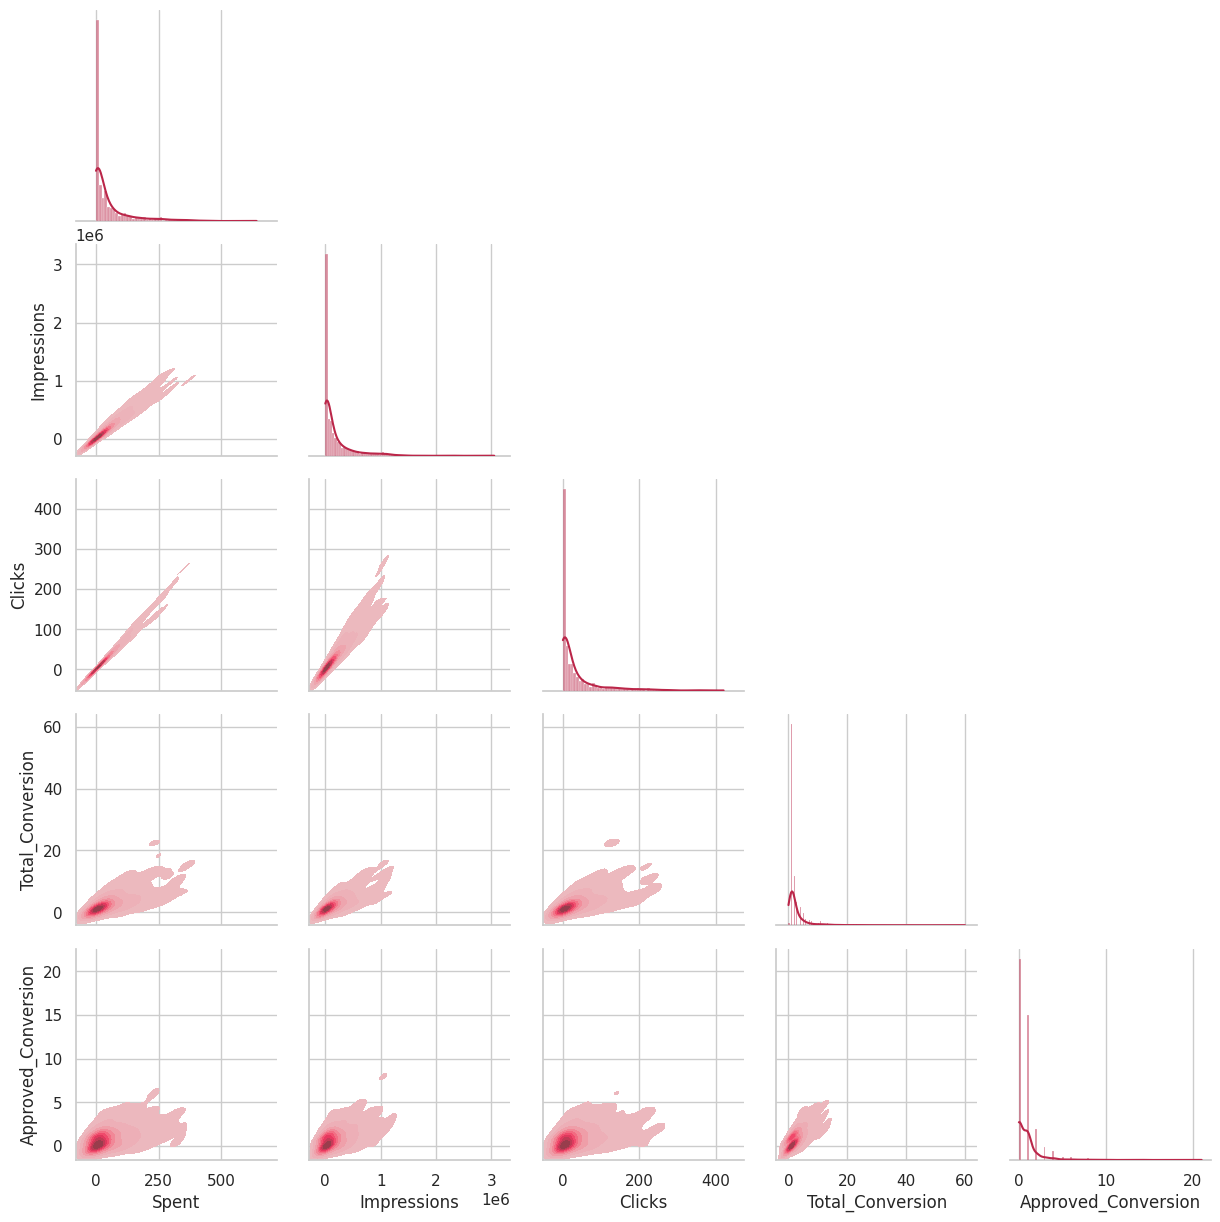

In [24]:
g=sns.PairGrid(df.toPandas(), vars=['Spent', 'Impressions', 'Clicks', 'Total_Conversion', 'Approved_Conversion'], diag_sharey=False, corner=True)
g.map_lower(sns.kdeplot, color="#BB2649", fill=True)
g.map_diag(sns.histplot, color="#BB2649", kde=True)
plt.savefig("correl.png")

In [25]:
spark.stop()